<a href="https://colab.research.google.com/github/escapingLife/mashinePrograming/blob/master/10%EC%A3%BC%EC%B0%A8/Simple_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -----------------------------------------------------------
# 개별 파일 읽기
# -----------------------------------------------------------
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# -----------------------------------------------------------
# 여러 파일을 읽어서 3차원 배열로 합치기
# -----------------------------------------------------------
def load_group(filenames, prefix=''):
    loaded = []
    for name in filenames:
        data = load_file(os.path.join(prefix, name))
        loaded.append(data)
    # features를 3번째 축으로 쌓기
    loaded = np.dstack(loaded)
    return loaded

# -----------------------------------------------------------
# train/test 그룹별 데이터 로드
# -----------------------------------------------------------
def load_dataset_group(group, dataset_path):
    signals_path = os.path.join(dataset_path, group, 'Inertial Signals')
    # 9개 시계열 파일 이름 지정
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt',  'body_acc_y_'+group+'.txt',  'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    # 입력 X 데이터
    X = load_group(filenames, signals_path)
    # 출력 y 데이터
    y = load_file(os.path.join(dataset_path, group, 'y_'+group+'.txt'))
    return X, y

# -----------------------------------------------------------
# 전체 데이터셋 로드 (train/test)
# -----------------------------------------------------------
def load_dataset(dataset_path):
    # train / test 데이터 불러오기
    trainX, trainy = load_dataset_group('train', dataset_path)
    testX, testy = load_dataset_group('test', dataset_path)

    # 라벨을 0부터 시작하도록 보정
    trainy = trainy - 1
    testy = testy - 1

    # 원-핫 인코딩
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)

    print(f"trainX: {trainX.shape}, trainy: {trainy.shape}, trainy_one_hot: {trainy_one_hot.shape}")
    print(f"testX: {testX.shape}, testy: {testy.shape}, testy_one_hot: {testy_one_hot.shape}")

    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

# -----------------------------------------------------------
# 실행
# -----------------------------------------------------------
# 🔹 네 폴더 구조에 맞게 경로 지정
dataset_path = r"/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset"

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset(dataset_path)

# -----------------------------------------------------------
# train 데이터를 다시 train/validation으로 분리
# -----------------------------------------------------------
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

print("\n데이터 분할 결과:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("y_train_one_hot:", y_train_one_hot.shape)
print("y_val_one_hot:", y_val_one_hot.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)

/tmp/ipython-input-456267969.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-456267969.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-456267969.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-456267969.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


trainX: (7352, 128, 9), trainy: (7352, 1), trainy_one_hot: (7352, 6)
testX: (2947, 128, 9), testy: (2947, 1), testy_one_hot: (2947, 6)

데이터 분할 결과:
X_train: (5881, 128, 9)
X_val: (1471, 128, 9)
y_train_one_hot: (5881, 6)
y_val_one_hot: (1471, 6)
y_train: (5881, 1)
y_val: (1471, 1)


/tmp/ipython-input-456267969.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [3]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 입력 차원
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

# 단순 CNN 모델
simple_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(n_outputs, activation='softmax')
])

# 모델 컴파일
simple_cnn.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
simple_cnn.summary()

# 학습
history = simple_cnn.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 28, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 14, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3584)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       458,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 584,710 (2.23 MB)

 Trainable params: 584,710 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.5810 - loss: 0.9717 - val_accuracy: 0.8981 - val_loss: 0.2608
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.8839 - loss: 0.3213 - val_accuracy: 0.9372 - val_loss: 0.1386
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9346 - loss: 0.1823 - val_accuracy: 0.9525 - val_loss: 0.1257
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9448 - loss: 0.1595 - val_accuracy: 0.9525 - val_loss: 0.1060
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9468 - loss: 0.1359 - val_accuracy: 0.9525 - val_loss: 0.1086
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.9501 - loss: 0.1320 - val_accuracy: 0.9643 - val_loss: 0.1022
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.9487 - loss: 0.1225 - val_accuracy: 0.9559 - val_loss: 0.0986
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9588 - loss: 0.1068 - val_a

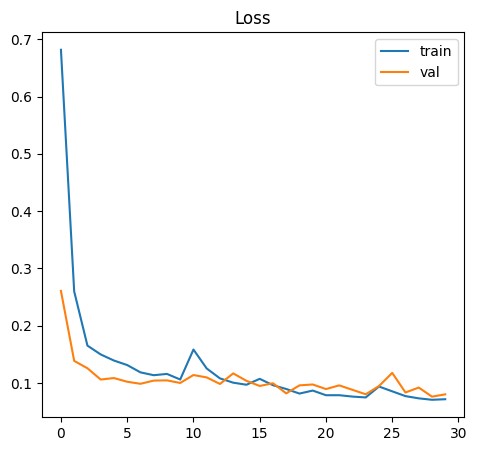

In [6]:
# -----------------------------------------------------------
# 손실 시각화
# -----------------------------------------------------------
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(loss, label='train')
plt.plot(val_loss, label='val')
plt.title('Loss')
plt.legend()

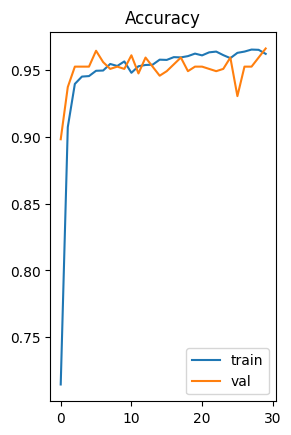

In [7]:
# -----------------------------------------------------------
# 정확도 시각화
# -----------------------------------------------------------
plt.subplot(1,2,2)
plt.plot(acc, label='train')
plt.plot(val_acc, label='val')
plt.title('Accuracy')
plt.legend()
plt.show()

In [11]:
# -----------------------------------------------------------
# 테스트 데이터 예측 및 평가
# -----------------------------------------------------------
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import numpy as np

pred = simple_cnn.predict(testX)
pred_classes = np.argmax(pred, axis=1)

cm = confusion_matrix(testy, pred_classes)
acc = accuracy_score(testy, pred_classes)
print("Test Accuracy:", acc)
print(classification_report(testy, pred_classes))



93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Test Accuracy: 0.9073634204275535
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       496
           1       0.88      0.97      0.92       471
           2       0.95      0.97      0.96       420
           3       0.78      0.86      0.82       491
           4       0.86      0.78      0.82       532
           5       1.00      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



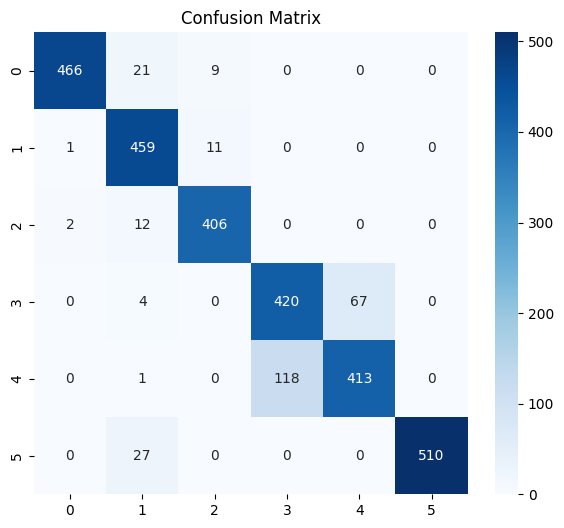

In [12]:
# -----------------------------------------------------------
# 혼동행렬 시각화
# -----------------------------------------------------------
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()